In [1]:
import csv
import torch
import torch.nn as nn
from torch.nn import functional as F
import warnings
warnings.filterwarnings('ignore')

In [3]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
def unicode_to_ascii(s):
    return ''.join(
    c for c in unicodedata.normalize('NFD', s)
    if unicodedata.category(c) != 'Mn'
    and c in all_letters
    )

print(unicode_to_ascii("ÿaman"))

yaman


In [39]:
from itertools import islice

training_examples = {}
n_categories = 2
categories = {'M': 1, 'F': 0}

with open('FirstNames.csv', 'r', encoding='latin-1') as f:
    reader = csv.reader(f)
    next(reader)   # skip the header row if it exists
    
    for row in reader:
        name = row[0].strip()
        name = unicode_to_ascii(name)
        gender = row[1].strip()
        
        training_examples[name] = int(gender)
    
for key, value in islice(training_examples.items(), 5):
    print(key, value)

Yash 1
Prit 1
Meet 1
Drashti 0
Saloni 0


In [5]:
# Turning names into Tensors
# TO represent a single letter, we use a "one-hot vector of size <1 x n_letters>"
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    letter_index = all_letters.find(letter)
    tensor[0][letter_index] = 1
    return tensor


# Turn a word into a tensor <word_length x 1 x n_letters>, 
# or an array of one-hot letter vectors
def name_to_tensor(word):
    tensor = torch.zeros(len(word), 1, n_letters)
    for li, letter in enumerate(word):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor

In [6]:
print(letter_to_tensor('a'))

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [7]:
print(name_to_tensor('rohan').size())

torch.Size([5, 1, 57])


### RNN architecture
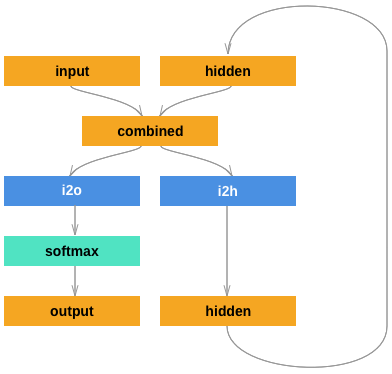

In [23]:
# Creating the Network
from torch.autograd import Variable

class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)  # Hidden cell that is feed to next cell
        self.i2o = nn.Linear(input_size + hidden_size, output_size)   # output cell
        self.sigmoid= nn.Sigmoid()
        
    def forward(self, inputt, hidden):
        combined = torch.cat((inputt, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.sigmoid(output)
        return output[0], hidden
    
    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))
        

In [24]:
# Testing Rnn
n_hidden = 128
rnn = RNN(n_letters, n_hidden, 1)

In [25]:
inputt = Variable(letter_to_tensor('A'))
hidden = rnn.init_hidden()

output, next_hidden = rnn(inputt, hidden)
print('output.size = ', output.size())

output.size =  torch.Size([1])


In [26]:
inputt = Variable(name_to_tensor('Ram'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(inputt[0], hidden)
print(output)

tensor([0.5003], grad_fn=<SelectBackward0>)


In [27]:
# Helper function to tell which category(Male/'M' or Female/'F') the output belongs to

def category_from_output(output):
    prob = output.data[0]
    if prob > 0.5:
        return 1, 'M'
    else:
        return 0, 'F'

category, category_label = category_from_output(output)
print(category, category_label)

1 M


In [28]:
# We will also want a quick way to get a training example (a name and its gender):
import random

def random_training_pair():
    # Select a random example from the dictionary
    name, gender = random.choice(list(training_examples.items()))

    # Convert gender label to category index (0 or 1)
    category = 'F' if gender == 0 else 'M'
    
    # Convert category to tensor
    category_tensor = Variable(torch.FloatTensor([0 if gender == 0 else 1]))
    
    name_tensor = Variable(name_to_tensor(name))
    
    return category, name, category_tensor, name_tensor 

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_pair()
    print('category =', category, 'name =', line)

category = M name = Haresh
category = F name = Veronica
category = F name = Manvi
category = F name = Snehal
category = F name = Hiti
category = M name = Kaustubh
category = M name = Umang
category = M name = Murili
category = F name = Rekha
category = M name = Shamil


## Training the Network

In [29]:
criterion = nn.BCELoss()

In [30]:
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

In [31]:
def train(category_tensor, name_tensor):
    rnn.zero_grad()
    hidden = rnn.init_hidden()
    
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    
    return output, loss.data

In [32]:
import math
import time

n_epochs = 100000
print_every = 5000
plot_every = 1000

# keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m , s)

start = time.time()

for epoch in range(1, n_epochs + 1):
    # Get a random training input and target
    category, line, category_tensor, line_tensor = random_training_pair()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    # print epoch number, loss and name and guess
    if epoch % print_every == 0:
        _, guess_i = category_from_output(output)
        correct = '✓' if guess_i == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess_i, correct))
    
    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 11s) 0.4077 Ishaan / M ✓
10000 10% (0m 24s) 1.3431 Shrenu / M ✗ (F)
15000 15% (0m 37s) 0.1874 Parvti / F ✓
20000 20% (0m 48s) 0.0395 Rubina / F ✓
25000 25% (1m 0s) 0.0159 Rakesh / M ✓
30000 30% (1m 12s) 0.1358 Jay / M ✓
35000 35% (1m 23s) 1.5942 Chahat / M ✗ (F)
40000 40% (1m 34s) 1.0211 Hinal / M ✗ (F)
45000 45% (1m 45s) 0.7473 Vinu / F ✗ (M)
50000 50% (1m 56s) 0.0402 Dakshita / F ✓
55000 55% (2m 7s) 0.0108 Soniya / F ✓
60000 60% (2m 21s) 1.0374 Raakhee / M ✗ (F)
65000 65% (2m 44s) 0.0056 Nisha / F ✓
70000 70% (3m 7s) 0.0636 Mahi / F ✓
75000 75% (3m 29s) 0.1031 Yagnik / M ✓
80000 80% (3m 51s) 0.3111 Jackky / M ✓
85000 85% (4m 14s) 0.0637 Arhaan / M ✓
90000 90% (4m 36s) 0.1934 Rizwan / M ✓
95000 95% (4m 59s) 0.6950 Mehul / F ✗ (M)
100000 100% (5m 21s) 0.0403 Tanmay / M ✓


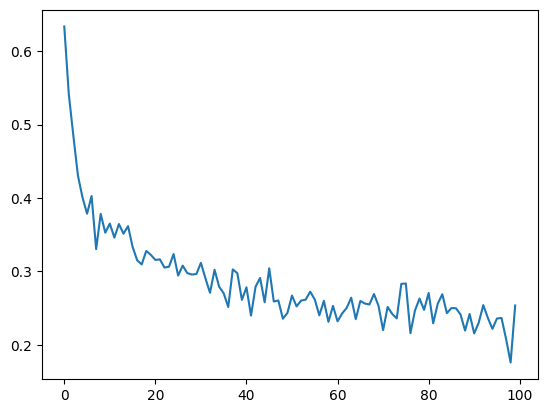

In [33]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

### Evaluate the Results

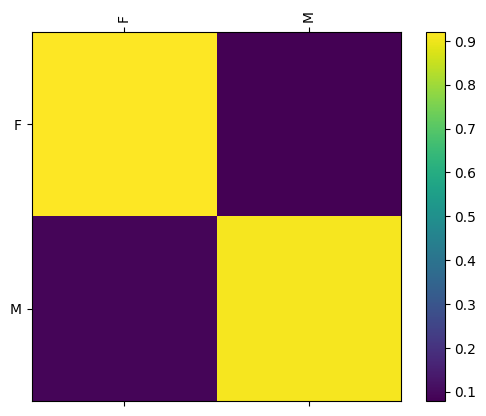

In [43]:
# keep track of correct guesses in a confusion matrix

all_categories = ['F', 'M']

confusion = torch.zeros(n_categories, n_categories)

n_confusion = 1000

# just return an output given a name
def evaluate(name_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
    return output

# GO through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, name, category_tensor, name_tensor = random_training_pair()
    output = evaluate(name_tensor)
    guess, guess_i = category_from_output(output)
    category_i = categories[category]
    confusion[category_i][guess] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

###  Running on User Input

In [71]:
def predict(input_name):
    print('\n> %s' % input_name)
    prob = evaluate(Variable(name_to_tensor(input_name)))
    
    # Get the corresponding gender
    output = 'M' if prob > 0.5 else  'F'
    print('(%.2f) %s' %(prob, output))

predict('Yaksh')
predict('Kartika')
predict('Navya')
predict('Kartik')


> Yaksh
(0.99) M

> Kartika
(0.00) F

> Navya
(0.06) F

> Kartik
(0.98) M
